/Users/aleksanderedemann/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:57: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=200,center=False).apply(func=<function>,args=<tuple>,kwargs=<dict>)
/Users/aleksanderedemann/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:71: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.


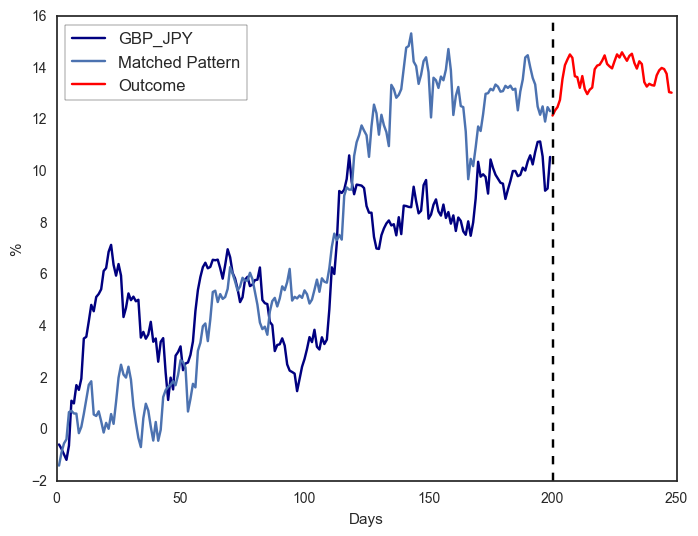

In [5]:
import seaborn as sns
import pandas as pd
import seaborn as sns
import oandapy
from pandas import Timedelta as td
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime as dt
import datetime as datetime


account = 'INSERT'
api_key = 'INSERT'

oanda = oandapy.API(environment="practice", access_token = api_key)

begdate = datetime.date(1990,1,1)
enddate = datetime.date.today()
ticker = 'GBP_JPY'
timeframe = 'D'

data = oanda.get_history(instrument=ticker,  # our instrument
                         start=begdate,  # start data
                         end=enddate,  # end date
                         granularity=timeframe,
                         timezone='Europe/Copenhagen')  # Timeframe

df = pd.DataFrame(data['candles']).set_index('time')  # Set time as the index

df.index = pd.DatetimeIndex(df.index)
px = df.closeAsk

#p= pattern length
p = 200
#o = outcome length
o = 50

i = len(px.index)-1

current_close = px.iloc[i]
current_date = px.index[i]

#historical data within to serach for similar patterns
h = px[:i-p]
cp = px.iloc[i-p:i]

def similar(x):
    sp_corr_value, sp_corr_pvalue = stats.pearsonr(cp.values,x)

    if sp_corr_value < sp_corr_pvalue: # correlation value returned by pearnson has to be grather than p_value
        return np.NAN   
    else:
        return sp_corr_value
    
# apply the correlation function every day 
correlation = pd.rolling_apply(h,p,similar)# apply the similar function to each row of the historical dataframe
correlation.name = 'corr'
correlation.dropna(inplace=True)

# adjust the correlation dataframe in order to pick just the highest values of correlation BUT 
# without any overlapping dates.. se the sext graph with blacks dots
df = pd.DataFrame(correlation).dropna()
df['date']=df.index
df.columns = ['corr', 'date']
df['delta'] = (df['date']-df['date'].shift(1))/pd.Timedelta('1 days')
df['delta'].fillna(p+1, inplace=True)
df['eval'] = df.apply(lambda x: x['date'] if x['delta'] >7 else np.NAN, axis=1)
df.fillna(method = 'pad', inplace=True)

pat = df['corr'].groupby(df['eval']).apply(lambda x: x.argmax())
max_corr = df['corr'].loc[[_ for _ in pat]]
max_corr.sort_values(ascending=False, inplace=True)
max_corr = max_corr[:1]
pat_names = max_corr.index

pat_list = [px.iloc[(i+1)-p:i+1] for i, date in enumerate(px.index) if date in pat_names]
out_list = [px.iloc[(i+1):(i+1)+o] for i, date in enumerate(px.index) if date in pat_names]
df_pat = pd.concat(pat_list, axis= 1)
df_out = pd.concat(out_list, axis=1)
df_pat.columns= pat_names
df_out.columns= pat_names

Cols = df_pat.columns
ild = np.split(df_pat, len(Cols), axis=1)
hd = np.split(df_out, len(Cols), axis=1)

q = pd.DataFrame(ild[0]).reset_index()
bb = hd[0].reset_index().dropna()
bb.index = list(range(199,249))
w = q.append(bb).dropna()
qq = pd.DataFrame(px)[-200:].reset_index()
RR = qq.merge(w,how='outer',left_index=True,right_index=True)
RR.columns = ['X','SPY','Y','Matched Pattern']
Plot = (RR.iloc[:,1::2].pct_change()*100).cumsum()

plt.figure(figsize=(8,6))
plt.plot(Plot['SPY'][:200],label=str(ticker),color='navy')
plt.plot(Plot['Matched Pattern'][:200],label='Matched Pattern')
plt.plot(Plot['Matched Pattern'][201:],color='red',label='Outcome') 
plt.grid(False)
plt.axvline(200,ls='--',color='black')
plt.legend(loc=2,frameon=1,fontsize='large')
plt.xlabel('Days')
plt.ylabel('%')

/Users/aleksanderedemann/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:70: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=200,center=False).apply(func=<function>,args=<tuple>,kwargs=<dict>)
/Users/aleksanderedemann/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:84: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
/Users/aleksanderedemann/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:70: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=200,center=False).apply(func=<function>,args=<tuple>,kwargs=<dict>)


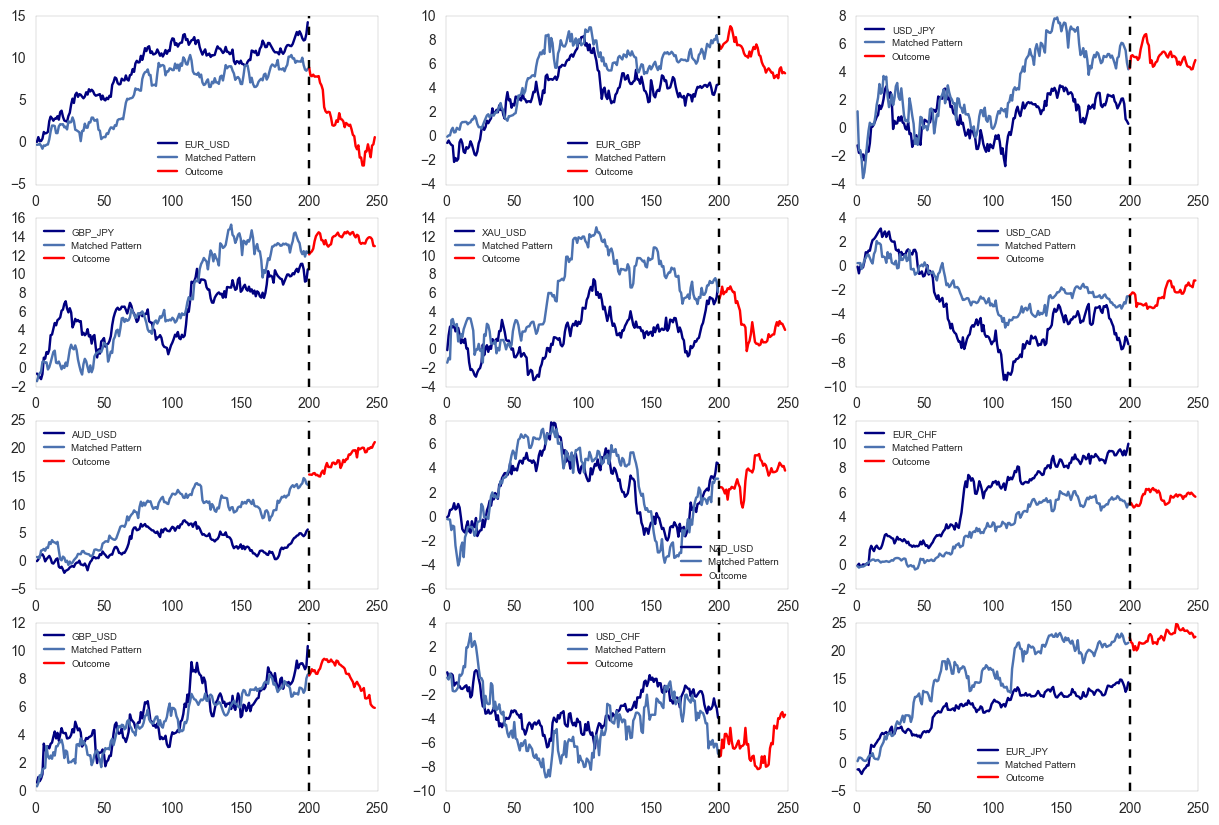

In [1]:
plt.style.use('seaborn-white')
plt.rcParams['axes.linewidth'] = 0.1

account = 'INSERT'
api_key = 'INSERT'

oanda = oandapy.API(environment="practice", access_token = api_key)

begdate = datetime.date(2000,1,1)
enddate = datetime.date.today()

ticker = ['EUR_USD','EUR_GBP','USD_JPY','GBP_JPY','XAU_USD','USD_CAD','AUD_USD','NZD_USD',
         'EUR_CHF','GBP_USD','USD_CHF','EUR_JPY']

timeframe = 'D'

fig, axes = plt.subplots(nrows=4,ncols=3, sharex=False,figsize=(15,10))

x = 0
y = 0


for ww in range(0,len(ticker)):
    data = oanda.get_history(instrument=ticker[ww],
                             start=begdate, 
                             end=enddate, 
                             granularity=timeframe,
                             timezone='Europe/Copenhagen')

    df = pd.DataFrame(data['candles']).set_index('time')  # Set time as the index
    df.index = pd.DatetimeIndex(df.index)
    px = df.closeAsk
    
        #p= pattern length
    p = 200
    #o = outcome length
    o = 50

    i = len(px.index)-1

    current_close = px.iloc[i]
    current_date = px.index[i]

    #historical data within to serach for similar patterns
    h = px[:i-p]
    cp = px.iloc[i-p:i]

    def similar(x):
        sp_corr_value, sp_corr_pvalue = stats.pearsonr(cp.values,x)

        if sp_corr_value < sp_corr_pvalue: # correlation value returned by pearnson has to be grather than p_value
            return np.NAN   
        else:
            return sp_corr_value

    # apply the correlation function every day 
    correlation = pd.rolling_apply(h,p,similar)# apply the similar function to each row of the historical dataframe
    correlation.name = 'corr'
    correlation.dropna(inplace=True)

    # adjust the correlation dataframe in order to pick just the highest values of correlation BUT 
    # without any overlapping dates.. se the sext graph with blacks dots
    df = pd.DataFrame(correlation).dropna()
    df['date']=df.index
    df.columns = ['corr', 'date']
    df['delta'] = (df['date']-df['date'].shift(1))/pd.Timedelta('1 days')
    df['delta'].fillna(p+1, inplace=True)
    df['eval'] = df.apply(lambda x: x['date'] if x['delta'] >7 else np.NAN, axis=1)
    df.fillna(method = 'pad', inplace=True)

    pat = df['corr'].groupby(df['eval']).apply(lambda x: x.argmax())
    max_corr = df['corr'].loc[[_ for _ in pat]]
    max_corr.sort_values(ascending=False, inplace=True)
    max_corr = max_corr[:1]
    pat_names = max_corr.index

    pat_list = [px.iloc[(i+1)-p:i+1] for i, date in enumerate(px.index) if date in pat_names]
    out_list = [px.iloc[(i+1):(i+1)+o] for i, date in enumerate(px.index) if date in pat_names]
    df_pat = pd.concat(pat_list, axis= 1)
    df_out = pd.concat(out_list, axis=1)
    df_pat.columns= pat_names
    df_out.columns= pat_names

    Cols = df_pat.columns
    ild = np.split(df_pat, len(Cols), axis=1)
    hd = np.split(df_out, len(Cols), axis=1)

    q = pd.DataFrame(ild[0]).reset_index()
    bb = hd[0].reset_index().dropna()
    bb.index = list(range(199,249))
    w = q.append(bb).dropna()
    qq = pd.DataFrame(px)[-200:].reset_index()
    RR = qq.merge(w,how='outer',left_index=True,right_index=True)
    RR.columns = ['X','SPY','Y','Matched Pattern']
    Plot = (RR.iloc[:,1::2].pct_change()*100).cumsum()
    
    axes[x,y].plot(Plot['SPY'][:200],label=str(ticker[ww]),color='navy')
    axes[x,y].plot(Plot['Matched Pattern'][:200],label='Matched Pattern')
    axes[x,y].plot(Plot['Matched Pattern'][201:],color='red',label='Outcome')  
    axes[x,y].grid(False)
    axes[x,y].axvline(200,ls='--',color='black')
    axes[x,y].legend(loc='best',fontsize='x-small')
    
    y+=1
    if y == 3:
        x+= 1
        y=0